# System Description
<!--
> The main goal of this first step is to describe the neural system of interest in such a way that the principles outlined in section 1.4 are directly applicable to it. In particular, available neuroanatomical data and any current functional understanding should be used to describ the architecture, function and representations of teh neural system. This description should include at least:
1. basic interconnectivity between subsystems (what is connected to what?)
2. neuron response functions (distributions of neuron parameters evident in the relevent populations)
3. neuron tuning curves (distributions of encoding functions of the relevant populations)
4. subsystem functional relations
5. overall system behavour

>The main purposes of this step are to 
1. identify the relevant neurobiological constraints
2. identify the represented system variables
3. rigorously relate those variables to one another in such a way that the observed behaviour results
-->

The goal of this system is to take two consecutive audio signals as input, and determine whether the second note is higher or lower than the first. This system will consist of two main components—a cochlea and a working memory. The cochlea will convert the audio signal into a N-dimensional vector (where N is the number of hair cell groups modeled in the cochlea). The cochlea performs a frequency decomposition of the given sound into N frequency bins, and outputs  a spike train with rates corresponding to the relative magnitudes of each frequency component. 

Without intensive training, or a neurological anomaly, there is generally no way to decode the root note (eg $A_4$) of a pitch directly from the auditory nerve, typically called *Perfect Pitch*. With somewhat less training however, it is possible to develop *Relative Pitch*, which is the ability to determine the value of a given pitch given a reference pitch. (A version of this where the reference pitch is engrained in long-term memory is typically indistinguishable form *Perfect Pitch*. Further, even an untrained listener (barring the condition amusia) can determine whether a pitch is higher or lower than a prior pitch. This last example is the basis of the system.

The N-dimensional vector representations of the input frequencies will be placed in a working-memory module. A comparison of the two stored vectors will be compared to output a final decision variable as the final response.

The final system diagram is shown below:

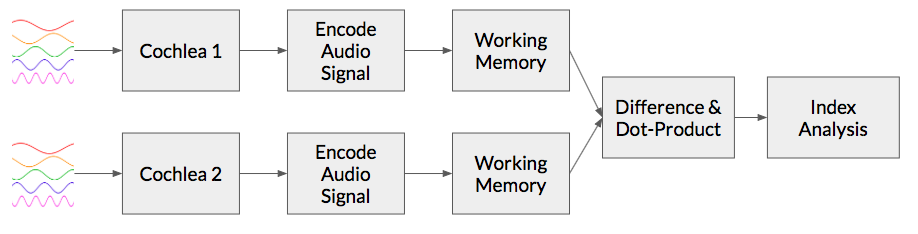

In [20]:
from IPython.display import Image
Image(filename='systemDiagram.png')

# Design Specification (and Implementational Constraints)
<!--
> The purpose of the design specification is to further delineate the real-world limitations that are known, or assumed for the neural system. As a result of the addendum, we must be explicit about the operating conditions that the system is subject to. This second step in the methodology explicitly demands stating the implementational constraints. So ,given the representation for each variabl as determined in the system description, the dnamic range, orecision and signal to noise ration for each degree of freedom of those variables must be specified.\

> The main purpose of this step is to precisely specify the implementational constraints on the model for each represented varaible identified in the previous step. -->

This system will only use pure sine-wave tones at given frequencies. Playing more complex timbres may introduce unneccessary complexity at this stage. A possible extension could be to add this versatility into the model. 

A second limitation in this model will be that the final interval (unison, perfect 5th, octave, etc.) will not be learned. An untrained listener is not able to determine much more than "higher" or "lower", and it takes training to determine the exact interval of the notes. A posible addition to the project could be to create a dictionary of results, and compare the result to elements in this dictionary. 

# Implementation
<!-- 
> The third step in the metodology involves generating and running the model itself. Given the system description and design specification, this step combines them to determine the appropriate decoding rules, and hence synaptic weights, needed to implement the desired behaviour.

> The main purpose of the final step of the methodology os to apply the principles of neural engineering outlined previously to embed the system description into a plausible neural model, and to analyze the experiment with the resulting simulation. -->

Auditory Periphery by Trevor Bekolay is a model of a cochlea and auditory system which takes a `nengo.Process` as input and outputs the spike train of the auditory nerve. This spike train can then be input into a working memory module for further processing.

In [1]:
import numpy as np
import scipy
import nengo
from nengo import spa
from nengo.processes import WhiteSignal
import nengo_gui
import matplotlib.pyplot as plt

import brian.hears as bh
from tbekolay import auditory_periphery as ap
from tbekolay import filters
from tbekolay import processes
from tbekolay import utils

In [2]:
def normalize(sig):
    return sig/float(np.max(np.abs(sig)))

def dotprod(x,y):
    dot = np.zeros(x.shape[0])
    for i in range (0, x.shape[0]):
        dot[i] = np.dot(x[i,:],y[i,:])
    return dot

A2_freq = 110.0
A3_freq = 220.0

C4_freq = 261.63
Db4_freq = 277.18
D4_freq = 293.66
Eb4_freq = 311.13
E4_freq = 329.63
F4_freq = 349.23
Gb4_freq = 369.99
G4_freq = 392.0
Ab4_freq = 415.30
A4_freq = 440.0
Bb4_freq = 466.16
B4_freq = 493.88
C5_freq = 523.25

A5_freq = 880.0
A6_freq = 1760.0
A7_freq = 3520.0

The Auditory Periphery model by Trevor Bekolay requires a `sound_process` as input. Here we create two processes that will be useful in the Perfect Pitch Model, since we need to play two tones into the cochlea. 

In [3]:
# Scavenge code from processes.Tone and processes.ToneRamp
# These processes are to be inputs into the Auditory Periphery model
class TwoTone(nengo.processes.Process):
    """Two tones seperated by silence"""
    def __init__(self, t_total=1.0, freq1=100., freq2=8000., rms=0.5):
        self.t_total = t_total
        self.freq1 = freq1
        self.freq2 = freq2
        self.rms = rms
        super(TwoTone, self).__init__()

    @property
    def rms(self):
        return self._rms

    @rms.setter
    def rms(self, _rms):
        self._rms = _rms
        self.amplitude = _rms * np.sqrt(2)

    def make_step(self, size_in, size_out, dt, rng):
        assert size_in[0] == 0
        assert size_out[0] == 1
        assert dt <= (1. / max(self.freq1, self.freq2))

        n_frames = int(self.t_total / dt)

        def func(t):
            if t < self.t_total/4.:
                return self.amplitude * np.sin(2 * np.pi * t * self.freq1)
            elif t < 2*self.t_total/4. and t > self.t_total/4.:
                return 0*t
            elif t < 3*self.t_total/4. and t > 2*self.t_total/4.:
                return self.amplitude * np.sin(2 * np.pi * t * self.freq2)
            else:
                return 0*t
        return func

class Tone_and_Silence(nengo.processes.Process):
    """A Single tone, followed by silence"""
    def __init__(self, t_total=1.0, freq=100., rms=0.5, quarter=1):
        self.t_total = t_total
        self.freq = freq
        self.rms = rms
        self.quarter = quarter
        super(Tone_and_Silence, self).__init__()

    @property
    def rms(self):
        return self._rms

    @rms.setter
    def rms(self, _rms):
        self._rms = _rms
        self.amplitude = _rms * np.sqrt(2)

    def make_step(self, size_in, size_out, dt, rng):
        assert size_in[0] == 0
        assert size_out[0] == 1
        assert dt <= (1. / self.freq)

        n_frames = int(self.t_total / dt)

        def func(t):
            if (t > (self.quarter-1)*self.t_total/4.) and (t < self.quarter*self.t_total/4.):
                return self.amplitude * np.sin(2 * np.pi * t * self.freq)
            else:
                return 0*t
        return func

## Using hyper-plane attractor as memory

The first attempt at making the Pitch Memory is to use a hyper-plane attractor as memory. This model doesn't do any comparison of notes yet, but is intended to validate the 32-dimensional hyper-plane.

In [4]:
f_min = 200 #hz
n_dims = 32
f_max = filters.melspace(200, 8000, 32)[n_dims-1]
f_sample = 16000.
N_neurons = 512
t_sim = 0.5

PitchMemoryModel = nengo.Network(label="Network")
with PitchMemoryModel:
    
    ##  ---  Set Sound Input  ---  ##
#     sound_process = processes.Tone(freq_in_hz = A4_freq)
#     sound_process = processes.ToneRamp(minfreq=200, maxfreq=500, t_ramp=0.1)
#     sound_process = processes.WhiteNoise()
#     sound_process = TwoTone(t_total = t_sim , freq1 = A4_freq, freq2 = B4_freq)
    sound_process = Tone_and_Silence(t_total = t_sim , freq = A4_freq)
    sound = nengo.Node(sound_process)
    
    ##  ---  Initiate the Cochlea  ---  ##
        # cochlea = nengo.networks.AuditoryPeriphery
    cochlea = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process,
                                   auditory_filter = "gammatone", fs = f_sample)
    # Auditory nerve synapse
    tau_an = 0.01
    
    ##  ---  Memory as a Plane Attractor  ---  ##
    memory = nengo.networks.EnsembleArray(N_neurons, n_ensembles=n_dims)
    nengo.Connection(cochlea.an.output, memory.input, synapse=tau_an, transform=0.25)
    nengo.Connection(memory.output, memory.input, synapse=tau_an)    
    
    ##   --- PROBES ---   ##
    sound_probe = nengo.Probe(sound)
    hair_probe = nengo.Probe(cochlea.ihc)
    cochlea_probe = nengo.Probe(cochlea.an.output, synapse=tau_an)
    mem_probe = nengo.Probe(memory.output, synapse=tau_an)

PitchSim = nengo.Simulator(PitchMemoryModel, dt=1./f_sample)
PitchSim.run(t_sim)
t = PitchSim.trange()

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:48.                                                 


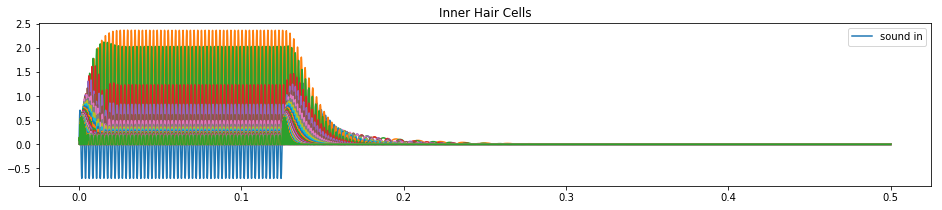

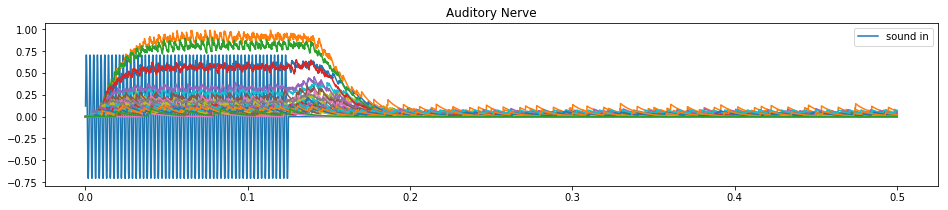

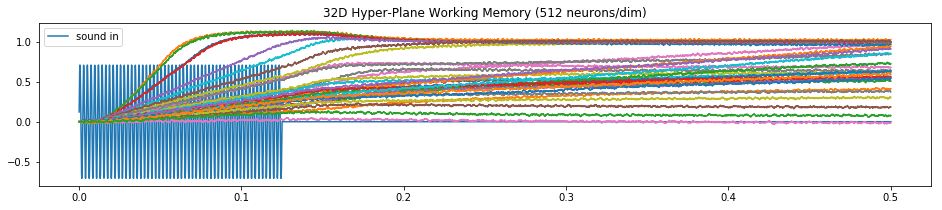

In [5]:
plt.figure(figsize=(16,3))
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe], label="sound in")
plt.plot(t, PitchSim.data[hair_probe])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,3))
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,3))
plt.title(str(n_dims) + "D Hyper-Plane Working Memory (" +str(N_neurons) +" neurons/dim)")
plt.plot(t, PitchSim.data[sound_probe], label="sound in")
plt.plot(t, PitchSim.data[mem_probe])
plt.legend(loc="best")
plt.show()

This model works fairly well, but there is no way to input two tones into the same cochlea and have the memory interpret the second tone as a new sound without a good deal of processing, which is out of scope for this project.

It looks like there are some saturation effects in this working memory. This can be resolved by increasing the radius of the ensemble.

### Let's make 2 ears & 2 memory planes

After validating the 32-D hyperplane works (albeit with a lot of neurons), I added a second input and cosrrespponding memory plane for the second tone. While the 32-dimensional hyperplane works as memory, when the second tone plays it adds to the 32-D memory instead of adding a second vector. In order to do this properly, adding content recognition would be required to discern when one note ends and the next begins to effectively switch the memory location and create a second vector. It may be possible to do this as a dot-product of the auditory nerve signals themselves, however this is out of scope. Other ways of doing this would be to perform a more temporal encoding of sounds, but this is also out of scope. Instead we will create two ears which listen to two different tones, and input these into the appropriate memory space. At this point, we dismiss most biological plausibility, since the goal was to be able to discern two notes played in series at a single ear, and we know it is possible to discern pitches using only one ear. 

The `bufferEns` ensemble could be thought of as the true working memory, since it stores both vectors, and the ensembles `memory_1` and `memory_2` as a sort of "pre-working-memory".

In [6]:
f_min = 200 #hz
n_dims = 16
f_max = filters.melspace(200, 8000, 32)[n_dims-1]
f_sample = 16000.
N_neurons = 512
t_sim = 0.25

PitchMemoryModel = nengo.Network(label="Network")
with PitchMemoryModel:
    
    ##  ---  Set Sound Input  ---  ##
#     sound_process = processes.Tone(freq_in_hz = A4_freq)
#     sound_process = processes.ToneRamp(minfreq=200, maxfreq=500, t_ramp=0.1)
#     sound_process = processes.WhiteNoise()
#     sound_process = TwoTone(t_total = t_sim , freq1 = A4_freq, freq2 = B4_freq)
    sound_process_1 = Tone_and_Silence(t_total = t_sim , freq = A4_freq)
    sound_process_2 = Tone_and_Silence(t_total = t_sim , freq = A4_freq)
    sound_1 = nengo.Node(sound_process_1)
    sound_2 = nengo.Node(sound_process_2)
    
    ##  ---  Initiate the Cochlea  ---  ##
        # cochlea = nengo.networks.AuditoryPeriphery
    cochlea_1 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_1,
                                   auditory_filter = "gammatone", fs = f_sample)
    cochlea_2 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_2,
                                   auditory_filter = "gammatone", fs = f_sample)
    # Auditory nerve synapse
    tau_an = 0.01
    
    ##  ---  Memory as a Plane Attractor  ---  ##
    memory_1 = nengo.networks.EnsembleArray(N_neurons*4, n_ensembles=n_dims, radius=2.)
    nengo.Connection(cochlea_1.an.output, memory_1.input, synapse=tau_an, transform=0.1) # by experimentation
    nengo.Connection(memory_1.output, memory_1.input, synapse=tau_an)   
    
    memory_2 = nengo.networks.EnsembleArray(N_neurons*4, n_ensembles=n_dims, radius=2.)
    nengo.Connection(cochlea_2.an.output, memory_2.input, synapse=tau_an, transform=0.1) # by experimentation
    nengo.Connection(memory_2.output, memory_2.input, synapse=tau_an)  
    
    # Set the buffer synapse
    tau_buff = tau_an
    
    bufferEns = nengo.Ensemble(N_neurons*4, dimensions = 2*n_dims, radius=1.5)
    nengo.Connection(memory_1.output, bufferEns[0:n_dims])
    nengo.Connection(memory_2.output, bufferEns[n_dims:2*n_dims])
    
    ##   --- PROBES ---   ##
    sound_probe_1 = nengo.Probe(sound_1)
    hair_probe_1 = nengo.Probe(cochlea_1.ihc)
    cochlea_probe_1 = nengo.Probe(cochlea_1.an.output, synapse=tau_an)
    mem_probe_1 = nengo.Probe(memory_1.output, synapse=tau_an)
    
    sound_probe_2 = nengo.Probe(sound_2)
    hair_probe_2 = nengo.Probe(cochlea_2.ihc)
    cochlea_probe_2 = nengo.Probe(cochlea_2.an.output, synapse=tau_an)
    mem_probe_2 = nengo.Probe(memory_2.output, synapse=tau_an)

PitchSim = nengo.Simulator(PitchMemoryModel, dt=1./f_sample)
PitchSim.run(t_sim)

Building finished in 0:00:40.                                                   
Simulating finished in 0:00:35.                                                 


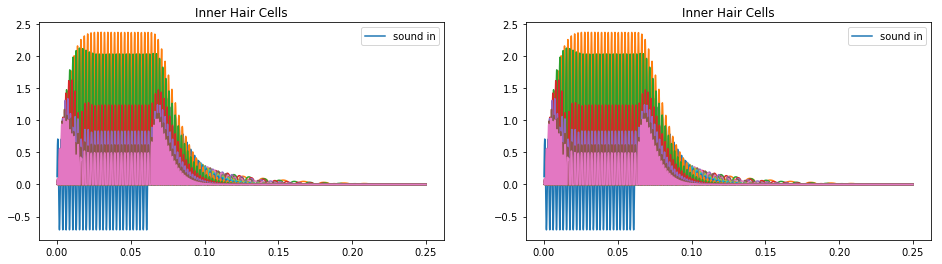

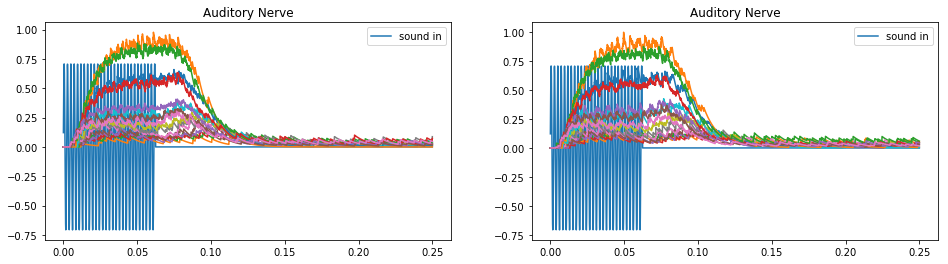

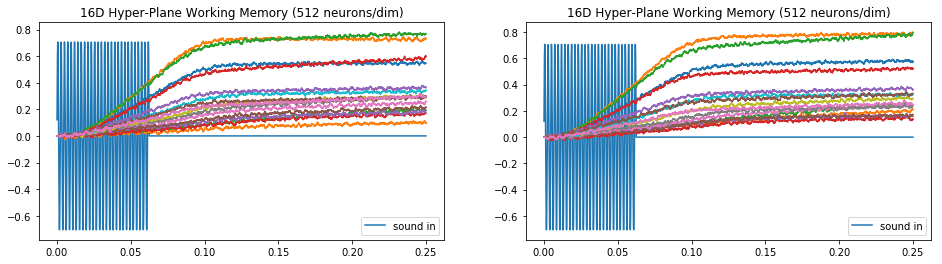

In [7]:
t = PitchSim.trange()
l = len(t)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title(str(n_dims) + "D Hyper-Plane Working Memory (" +str(N_neurons) +" neurons/dim)")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[mem_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title(str(n_dims) + "D Hyper-Plane Working Memory (" +str(N_neurons) +" neurons/dim)")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[mem_probe_2])
plt.legend(loc="best")
plt.show()

### Getting the Dot-Product Calculator to Work

Next we must somehow compare the two signals in memory. One way to do this is using the dot-product. Below is some experimentation code to figure out how to calculate the dot-product of two n-dimensional signals. Since there are two operations done in a dot product, and the computation: `function = np.dot(x[0:nD],x[nD:2*nD])` does not run, two extra ensembles are required.

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


/Users/adam/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


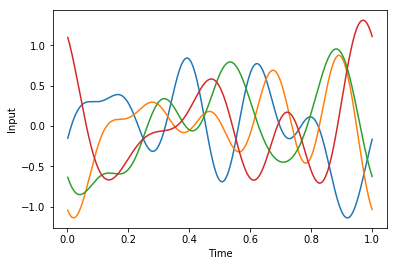

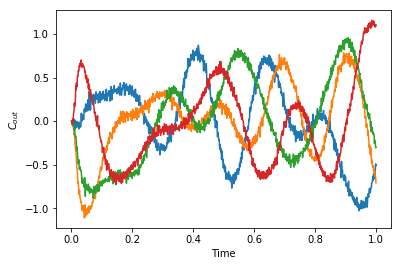

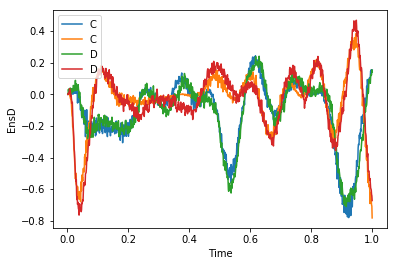

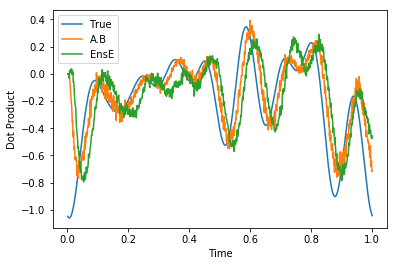

In [8]:
import nengo
from nengo.processes import WhiteNoise
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    nD = 2
    stimA = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.5), size_out=nD)
    stimB = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.5), size_out=nD)
    
    ensA = nengo.Ensemble(50, dimensions=nD)
    ensB = nengo.Ensemble(50, dimensions=nD)
    
    # Can't use EnsembleArray since it causes error "Cannot apply functions to passthrough nodes" 
    # when setting up nengo.Connection with `function` parameter
    # ensC = nengo.networks.EnsembleArray(200, n_ensembles = 2 , ens_dimensions=nD)
   
    ensC2 = nengo.Ensemble(400, dimensions=2*nD, radius=2) #increasing radius allows it to 
                                                           #better track the input as it comes close to 1
    ensD = nengo.Ensemble(200, dimensions=nD)
    ensE = nengo.Ensemble(200, dimensions=1, radius=2)
    
    def prodArray(x):
        return x[0:nD]*x[nD:2*nD]
    def sumArray(x):
        return np.sum(x)
    def dotProd(x):
        return np.dot(x[0:nD],x[nD:2*nD])
    
    nengo.Connection(stimA, ensA)
    nengo.Connection(stimB, ensB)
    # nengo.Connection(ensA, ensC.input[0:nD])
    # nengo.Connection(ensB, ensC.input[nD:2*nD])
    nengo.Connection(ensA, ensC2[0:nD])
    nengo.Connection(ensB, ensC2[nD:2*nD])
    nengo.Connection(ensC2, ensD, function=prodArray)
    nengo.Connection(ensD, ensE, function=sumArray)
    
    stimA_p = nengo.Probe(stimA)
    stimB_p = nengo.Probe(stimB)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    
    ensC2_p = nengo.Probe(ensC2, synapse=.01)
    ensC2in0_p = nengo.Probe(ensC2[0:2], synapse=.01)
    ensC2in1_p = nengo.Probe(ensC2[2:4], synapse=.01)
    ensC2in_p = nengo.Probe(ensC2, synapse=.01)
    
    ensD_p = nengo.Probe(ensD, synapse=.01)
    ensE_p = nengo.Probe(ensE, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(T)
t = sim.trange()

plt.figure()
plt.plot(t, sim.data[stimA_p])
plt.plot(t, sim.data[stimB_p])
plt.legend(loc='best')
plt.ylabel("Input")
plt.xlabel("Time")
plt.show()

plt.figure()
plt.plot(t, sim.data[ensC2_p])
plt.legend(loc='best')
plt.ylabel("$C_{out}$")
plt.xlabel("Time")
plt.show()

plt.figure()
plt.plot(t, np.transpose(prodArray(np.transpose(sim.data[ensC2_p]))), label="C")
plt.plot(t, sim.data[ensD_p], label="D")
plt.legend(loc='best')
plt.ylabel("EnsD")
plt.xlabel("Time")
plt.show();

plt.figure()
plt.plot(t, dotprod(sim.data[stimA_p],sim.data[stimB_p]), label="True")
plt.plot(t, dotprod(sim.data[ensA_p],sim.data[ensB_p]), label="A.B")
plt.plot(t, sim.data[ensE_p], label="EnsE")
plt.legend(loc='best')
plt.ylabel("Dot Product")
plt.xlabel("Time")
plt.show();

### Implementing Dot Product Calculation

Here we translate the above code into the cochlea-memory model

In [9]:
f_min = 200 #hz
n_dims = 16
f_max = filters.melspace(200, 8000, 32)[n_dims-1]
f_sample = 16000.
N_neurons = 512
t_sim = 0.25

PitchMemoryModel = nengo.Network(label="Network")
with PitchMemoryModel:
    
    ##  ---  Set Sound Input  ---  ##
#     sound_process = processes.Tone(freq_in_hz = A4_freq)
#     sound_process = processes.ToneRamp(minfreq=200, maxfreq=500, t_ramp=0.1)
#     sound_process = processes.WhiteNoise()
#     sound_process = TwoTone(t_total = t_sim , freq1 = A4_freq, freq2 = B4_freq)
    sound_process_1 = Tone_and_Silence(t_total = t_sim , freq = A4_freq)
    sound_process_2 = Tone_and_Silence(t_total = t_sim , freq = A4_freq)
    sound_1 = nengo.Node(sound_process_1)
    sound_2 = nengo.Node(sound_process_2)
    
    ##  ---  Initiate the Cochlea  ---  ##
        # cochlea = nengo.networks.AuditoryPeriphery
    cochlea_1 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_1,
                                   auditory_filter = "gammatone", fs = f_sample)
    cochlea_2 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_2,
                                   auditory_filter = "gammatone", fs = f_sample)
    # Auditory nerve synapse
    tau_an = 0.01
    
    ##  ---  Memory as a Plane Attractor  ---  ##
    memory_1 = nengo.networks.EnsembleArray(N_neurons*4, n_ensembles=n_dims, radius=2.)
    nengo.Connection(cochlea_1.an.output, memory_1.input, synapse=tau_an, transform=0.1) # by experimentation
    nengo.Connection(memory_1.output, memory_1.input, synapse=tau_an)   
    
    memory_2 = nengo.networks.EnsembleArray(N_neurons*4, n_ensembles=n_dims, radius=2.)
    nengo.Connection(cochlea_2.an.output, memory_2.input, synapse=tau_an, transform=0.1) # by experimentation
    nengo.Connection(memory_2.output, memory_2.input, synapse=tau_an)  
    
    # Set the buffer synapse
    tau_buff = tau_an
    
    def prodArray(x):
        return x[0:n_dims]*x[n_dims:2*n_dims]
    def sumArray(x):
        return np.sum(x)
    
    bufferEns = nengo.Ensemble(N_neurons*4, dimensions = 2*n_dims, radius=1.5)
    nengo.Connection(memory_1.output, bufferEns[0:n_dims])
    nengo.Connection(memory_2.output, bufferEns[n_dims:2*n_dims])
    
    prodBuffer = nengo.Ensemble(N_neurons*2, dimensions=n_dims)
    nengo.Connection(bufferEns, prodBuffer, function=prodArray)
    
    dotProd = nengo.Ensemble(N_neurons, dimensions=1, radius=1.1)
    nengo.Connection(prodBuffer, dotProd, function=sumArray)
    
    ##   --- PROBES ---   ##
    sound_probe_1 = nengo.Probe(sound_1)
    hair_probe_1 = nengo.Probe(cochlea_1.ihc)
    cochlea_probe_1 = nengo.Probe(cochlea_1.an.output, synapse=tau_an)
    mem_probe_1 = nengo.Probe(memory_1.output, synapse=tau_an)
    
    sound_probe_2 = nengo.Probe(sound_2)
    hair_probe_2 = nengo.Probe(cochlea_2.ihc)
    cochlea_probe_2 = nengo.Probe(cochlea_2.an.output, synapse=tau_an)
    mem_probe_2 = nengo.Probe(memory_2.output, synapse=tau_an)

    buffer_probe = nengo.Probe(bufferEns, synapse=0.05)
    
    dotProd_probe = nengo.Probe(dotProd, synapse=0.05)

PitchSim = nengo.Simulator(PitchMemoryModel, dt=1./f_sample)
PitchSim.run(t_sim)

Building finished in 0:00:35.                                                   
Simulating finished in 0:00:36.                                                 


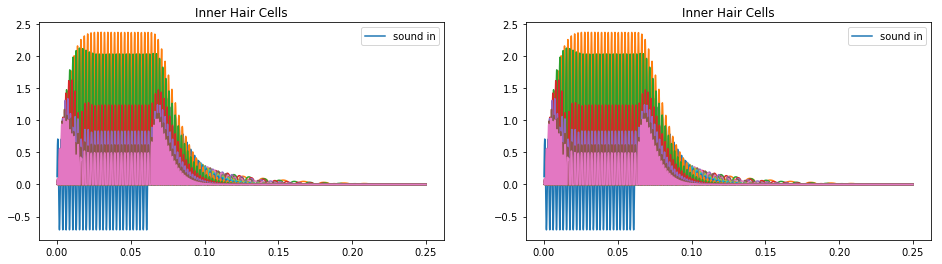

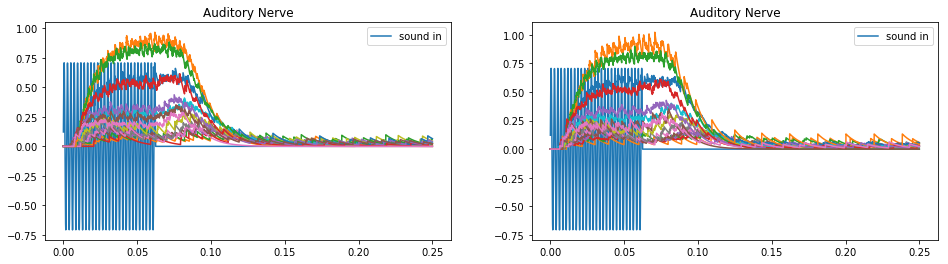

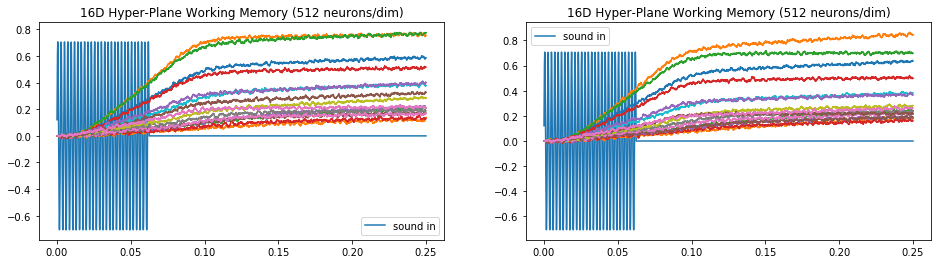

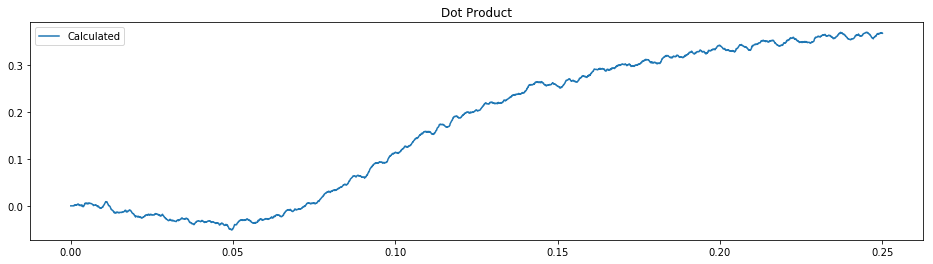

In [10]:
t = PitchSim.trange()
l = len(t)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title(str(n_dims) + "D Hyper-Plane Working Memory (" +str(N_neurons) +" neurons/dim)")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[mem_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title(str(n_dims) + "D Hyper-Plane Working Memory (" +str(N_neurons) +" neurons/dim)")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[mem_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.title('Dot Product')
# plt.plot(t, normalize(dotprod(PitchSim.data[mem_probe_1], PitchSim.data[mem_probe_2])), label="True")
plt.plot(t, (PitchSim.data[dotProd_probe]), label="Calculated")
plt.legend()
plt.show()

### Consolidating the Memory Plane, and difference comparison

Instead of using 2 memories, we can use one large (2N-dimensional) memory as an attempt to be more biologically plausible.

We also try a different comparison method—calculating the difference between the vectors.
The dot product is good at calculating difference (rather, similarity) but does not get us toward our goal of determining direction (higher or lower pitch). In order to do this, we compute the difference in each component of the vector. Next, we find the components with the max and min differences. If the argmax is higher than the argmin, then the tones are going up. If argmax is lower than argmin, then the tones are going down. 

In [11]:
f_min = 200 #hz
n_dims = 32
f_max = filters.melspace(200, 8000, 32)[n_dims-1]
f_sample = 16000.
N_neurons = 512
t_sim = 0.5

PitchMemoryModel = nengo.Network(label="Network")
with PitchMemoryModel:
    
    ##  ---  Set Sound Input  ---  ##
#     sound_process = processes.Tone(freq_in_hz = A4_freq)
#     sound_process = processes.ToneRamp(minfreq=200, maxfreq=500, t_ramp=0.1)
#     sound_process = processes.WhiteNoise()
#     sound_process = TwoTone(t_total = t_sim , freq1 = A4_freq, freq2 = B4_freq)
    sound_process_1 = Tone_and_Silence(t_total = t_sim , freq = A4_freq, quarter=1)
    sound_process_2 = Tone_and_Silence(t_total = t_sim , freq = A3_freq, quarter=2)
    sound_1 = nengo.Node(sound_process_1)
    sound_2 = nengo.Node(sound_process_2)
    
    ##  ---  Initiate the Cochlea  ---  ##
        # cochlea = nengo.networks.AuditoryPeriphery
    cochlea_1 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_1,
                                   auditory_filter = "gammatone", fs = f_sample)
    cochlea_2 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_2,
                                   auditory_filter = "gammatone", fs = f_sample)
    # Auditory nerve synapse
    tau_an = 0.01
    
    ##  ---  Memory as a Plane Attractor  ---  ##
    full_mem = nengo.Ensemble(N_neurons*12, dimensions=2*n_dims, radius=2.)
    nengo.Connection(cochlea_1.an.output, full_mem[0:n_dims], synapse=tau_an, transform=0.1)
    nengo.Connection(cochlea_2.an.output, full_mem[n_dims:2*n_dims], synapse=tau_an, transform=0.1)
    nengo.Connection(full_mem[0:n_dims], full_mem[0:n_dims], synapse=tau_an, transform=1.1)
    nengo.Connection(full_mem[n_dims:2*n_dims], full_mem[n_dims:2*n_dims], synapse=tau_an, transform=1.1) 
    
    def prodArray(x):
        return x[0:n_dims]*x[n_dims:2*n_dims]
    def sumArray(x):
        return np.sum(x)
    def diffArray(x):
        return x[n_dims:2*n_dims] - x[0:n_dims]
    
    diffEns = nengo.Ensemble(N_neurons*4, dimensions=n_dims)
    nengo.Connection(full_mem, diffEns, function=diffArray)
    
    id_max_min = nengo.Ensemble(N_neurons, dimensions=2, radius=n_dims)
    id_diff = nengo.Ensemble(N_neurons, dimensions=1, radius=n_dims)
    
    nengo.Connection(diffEns, id_max_min[0], function=np.argmax, synapse=tau_an)
    nengo.Connection(diffEns, id_max_min[1], function=np.argmin, synapse=tau_an)
    nengo.Connection(id_max_min, id_diff, function=lambda x: x[0]-x[1], synapse=tau_an)
    
    ##   --- PROBES ---   ##
    sound_probe_1 = nengo.Probe(sound_1)
    hair_probe_1 = nengo.Probe(cochlea_1.ihc)
    cochlea_probe_1 = nengo.Probe(cochlea_1.an.output, synapse=tau_an)
    
    sound_probe_2 = nengo.Probe(sound_2)
    hair_probe_2 = nengo.Probe(cochlea_2.ihc)
    cochlea_probe_2 = nengo.Probe(cochlea_2.an.output, synapse=tau_an)
    
    fullMem_probe = nengo.Probe(full_mem, synapse=0.01)
    
    diff_probe = nengo.Probe(diffEns, synapse=0.01)
    idMax_probe = nengo.Probe(id_max_min, synapse=0.01)
    idDiff_probe = nengo.Probe(id_diff, synapse=0.01)
    
PitchSim = nengo.Simulator(PitchMemoryModel, dt=1./f_sample)
PitchSim.run(t_sim)

Building finished in 0:01:20.                                                   
Simulating finished in 0:00:46.                                                 


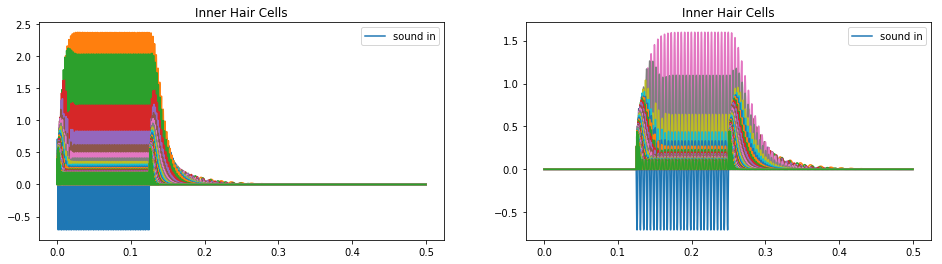

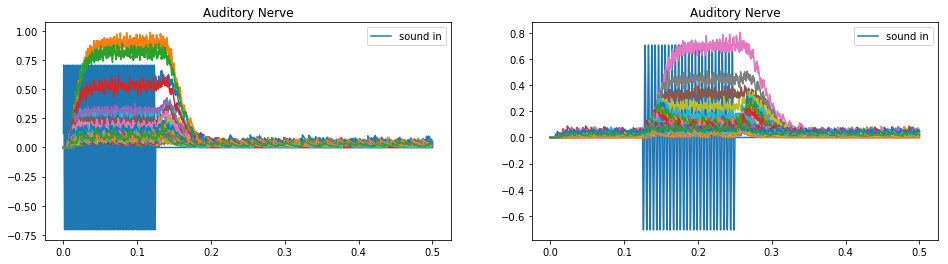

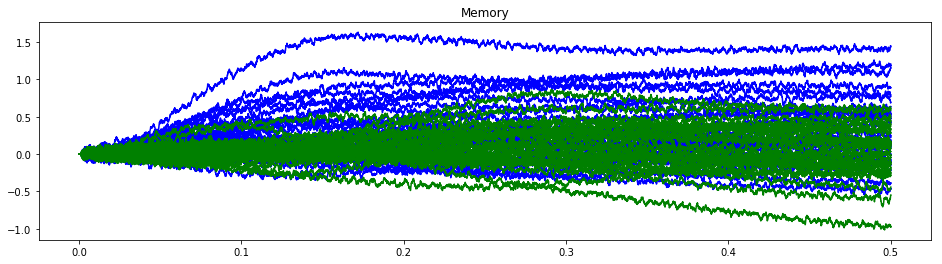

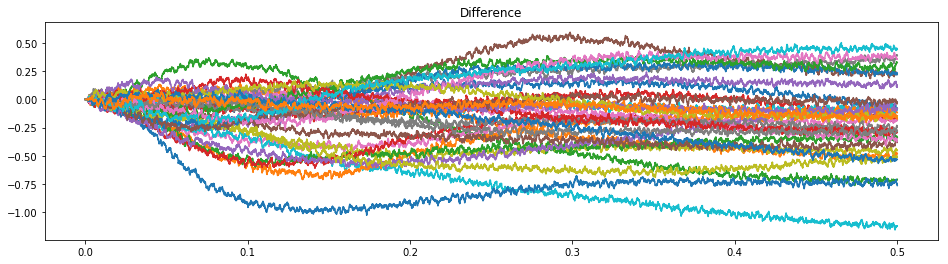

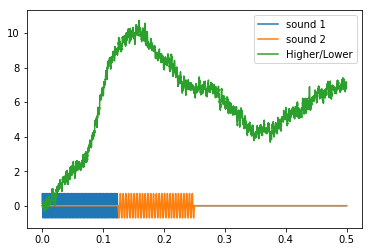

In [12]:
t = PitchSim.trange()
l = len(t)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.title('Memory')
plt.plot(t, PitchSim.data[fullMem_probe][:,0:n_dims], color='b')
plt.plot(t, PitchSim.data[fullMem_probe][:,n_dims:2*n_dims], color='g')
plt.show()

plt.figure(figsize=(16,4))
plt.title('Difference')
plt.plot(t, (PitchSim.data[diff_probe]))
# plt.legend()
plt.show()

# plt.figure()
# plt.plot( np.transpose(PitchSim.data[diff_probe])[::,int(f_sample*0.2) : int(f_sample*0.25)] )
# plt.show()

# print PitchSim.data[idMax_probe][int(f_sample*0.125) : int(f_sample*0.375)]

# for i in range(int(f_sample*0.125), int(f_sample*0.375)):
#     print str(np.argmax(PitchSim.data[diff_probe][i])) + ", " + str(np.argmin(PitchSim.data[diff_probe][i]))

plt.figure()
plt.plot(t, PitchSim.data[sound_probe_1], label="sound 1")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound 2")
plt.plot(t, PitchSim.data[idDiff_probe], label="Higher/Lower")
plt.legend()
plt.show()

toWrite = PitchSim.data[sound_probe_1] + PitchSim.data[sound_probe_2]

scipy.io.wavfile.write("tones.wav", 16000, toWrite)

### Back to two-plane memory

That single consoltdated memory doesn't really seem to work all that well; it doesn't seem that the increase of neurons necessary to increase the number of dimensions is close to linear. Let's go back to the two-plane memory, but use the difference computing neurons used here as the main high/low comparison. 

In [18]:
f_min = 200 #hz
n_dims = 32
f_max = filters.melspace(200, 8000, 32)[n_dims-1]
f_sample = 16000.
N_neurons = 512
t_sim = 0.25

PitchMemoryModel = nengo.Network(label="Network")
with PitchMemoryModel:
    
    ##  ---  Set Sound Input  ---  ##
#     sound_process = processes.Tone(freq_in_hz = A4_freq)
#     sound_process = processes.ToneRamp(minfreq=200, maxfreq=500, t_ramp=0.1)
#     sound_process = processes.WhiteNoise()
#     sound_process = TwoTone(t_total = t_sim , freq1 = A4_freq, freq2 = B4_freq)
    sound_process_1 = Tone_and_Silence(t_total = t_sim , freq = Ab4_freq, quarter=1)
    sound_process_2 = Tone_and_Silence(t_total = t_sim , freq = C5_freq, quarter=2)
    sound_1 = nengo.Node(sound_process_1)
    sound_2 = nengo.Node(sound_process_2)
    
    ##  ---  Initiate the Cochlea  ---  ##
        # cochlea = nengo.networks.AuditoryPeriphery
    cochlea_1 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_1,
                                   auditory_filter = "gammatone", fs = f_sample)
    cochlea_2 = ap.AuditoryPeriphery(freqs = filters.melspace(f_min, f_max, n_dims), 
                                   sound_process = sound_process_2,
                                   auditory_filter = "gammatone", fs = f_sample)
    # Auditory nerve synapse
    tau_an = 0.01
    
    ##  ---  Memory as a Plane Attractor  ---  ##
    memory_1 = nengo.networks.EnsembleArray(N_neurons*4, n_ensembles=n_dims, radius=2.)
    nengo.Connection(cochlea_1.an.output, memory_1.input, synapse=tau_an, transform=0.1) # by experimentation
    nengo.Connection(memory_1.output, memory_1.input, synapse=tau_an)   
    
    memory_2 = nengo.networks.EnsembleArray(N_neurons*4, n_ensembles=n_dims, radius=2.)
    nengo.Connection(cochlea_2.an.output, memory_2.input, synapse=tau_an, transform=0.1) # by experimentation
    nengo.Connection(memory_2.output, memory_2.input, synapse=tau_an)  
    
    def prodArray(x):
        return x[0:n_dims]*x[n_dims:2*n_dims]
    def sumArray(x):
        return np.sum(x)
    def diffArray(x):
        return x[n_dims:2*n_dims] - x[0:n_dims]
    def decide(x):
        return np.sign(x)*np.round(np.abs(x))
    
    bufferEns = nengo.Ensemble(N_neurons*4, dimensions = 2*n_dims, radius=1.5)
    nengo.Connection(memory_1.output, bufferEns[0:n_dims])
    nengo.Connection(memory_2.output, bufferEns[n_dims:2*n_dims])
    
    diffEns = nengo.Ensemble(N_neurons*4, dimensions=n_dims)
    nengo.Connection(bufferEns, diffEns, function=diffArray)
    
    id_max_min = nengo.Ensemble(N_neurons, dimensions=2, radius=n_dims)
    id_diff = nengo.Ensemble(N_neurons, dimensions=1)
    finalDecision = nengo.Ensemble(N_neurons//2, dimensions=1)
    
    nengo.Connection(diffEns, id_max_min[0], function=np.argmax, synapse=tau_an)
    nengo.Connection(diffEns, id_max_min[1], function=np.argmin, synapse=tau_an)
    nengo.Connection(id_max_min, id_diff, function=lambda x: x[0]-x[1], synapse=tau_an)
    nengo.Connection(id_diff, finalDecision, function=decide, synapse=tau_an)
    
    prodBuffer = nengo.Ensemble(N_neurons*2, dimensions=n_dims)
    nengo.Connection(bufferEns, prodBuffer, function=prodArray)
    
    dotProd = nengo.Ensemble(N_neurons, dimensions=1, radius=1.1)
    nengo.Connection(prodBuffer, dotProd, function=sumArray)
    
    
    ##   --- PROBES ---   ##
    sound_probe_1 = nengo.Probe(sound_1)
    hair_probe_1 = nengo.Probe(cochlea_1.ihc)
    cochlea_probe_1 = nengo.Probe(cochlea_1.an.output, synapse=tau_an)
    mem_probe_1 = nengo.Probe(memory_1.output, synapse=tau_an)
    
    sound_probe_2 = nengo.Probe(sound_2)
    hair_probe_2 = nengo.Probe(cochlea_2.ihc)
    cochlea_probe_2 = nengo.Probe(cochlea_2.an.output, synapse=tau_an)
    mem_probe_2 = nengo.Probe(memory_2.output, synapse=tau_an)

    buffer_probe = nengo.Probe(bufferEns, synapse=0.01)
    
    diff_probe = nengo.Probe(diffEns, synapse=0.01)
    idMax_probe = nengo.Probe(id_max_min, synapse=0.01)
    idDiff_probe = nengo.Probe(id_diff, synapse=0.01)
    decision_probe = nengo.Probe(finalDecision, synapse=0.01)
    
    dotProd_probe = nengo.Probe(dotProd, synapse=0.05)
    
PitchSim = nengo.Simulator(PitchMemoryModel, dt=1./f_sample)
PitchSim.run(t_sim)

Building finished in 0:01:14.                                                   
Simulating finished in 0:01:01.                                                 


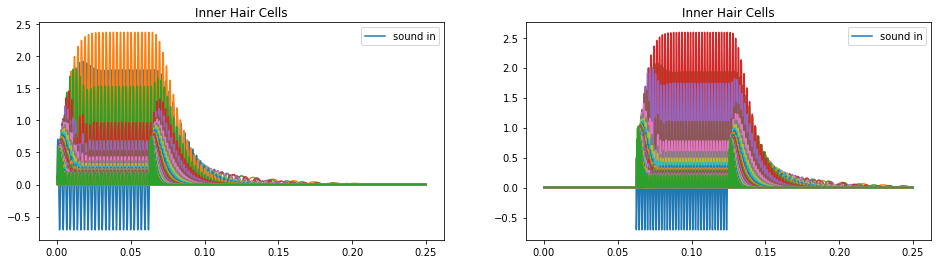

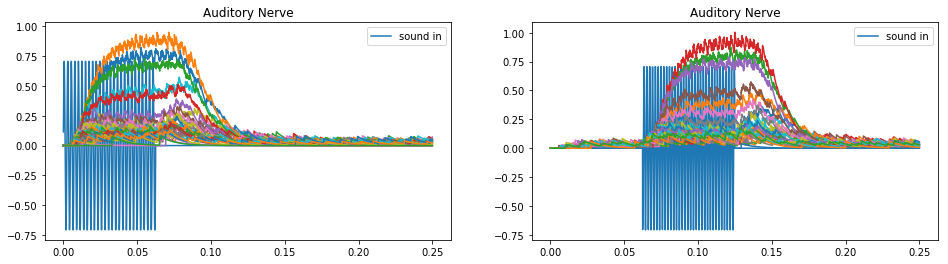

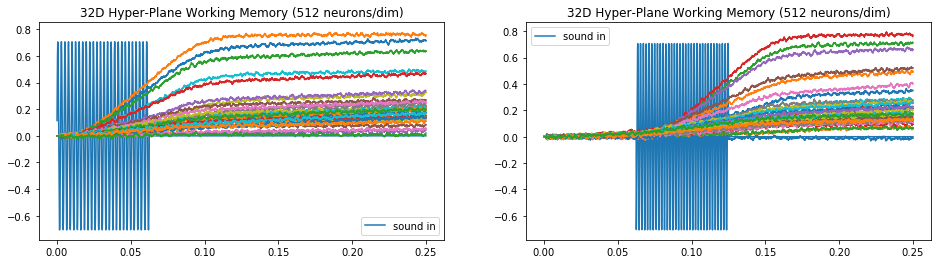

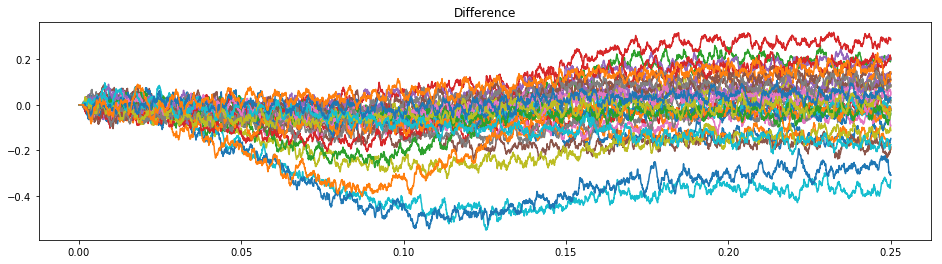

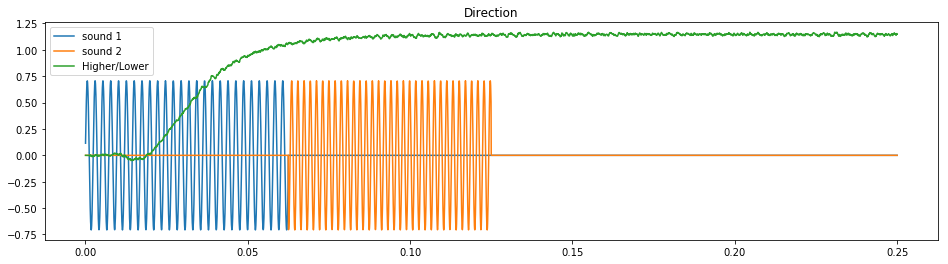

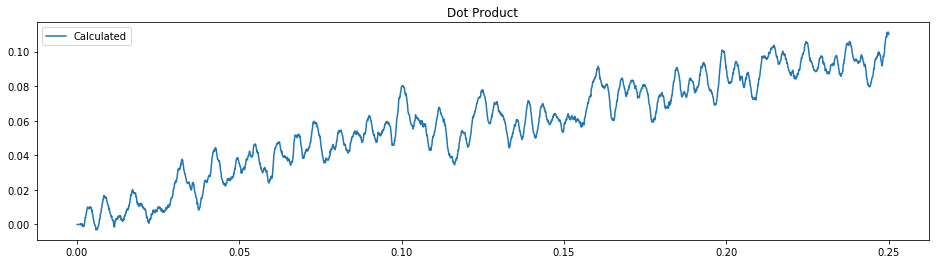

In [19]:
t = PitchSim.trange()
l = len(t)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Inner Hair Cells")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[hair_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title("Auditory Nerve")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[cochlea_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title(str(n_dims) + "D Hyper-Plane Working Memory (" + str(N_neurons) +" neurons/dim)")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound in")
plt.plot(t, PitchSim.data[mem_probe_1])
plt.legend(loc="best")
plt.subplot(122)
plt.title(str(n_dims) + "D Hyper-Plane Working Memory (" + str(N_neurons) +" neurons/dim)")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound in")
plt.plot(t, PitchSim.data[mem_probe_2])
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.title('Difference')
plt.plot(t, (PitchSim.data[diff_probe]))
plt.show()

plt.figure(figsize=(16,4))
plt.title("Direction")
plt.plot(t, PitchSim.data[sound_probe_1], label="sound 1")
plt.plot(t, PitchSim.data[sound_probe_2], label="sound 2")
plt.plot(t, PitchSim.data[decision_probe], label="Higher/Lower")
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(16,4))
plt.title('Dot Product')
plt.plot(t, (PitchSim.data[dotProd_probe]), label="Calculated")
plt.legend()
plt.show()

toWrite = np.transpose(np.array([np.transpose(PitchSim.data[sound_probe_1]), np.transpose(PitchSim.data[sound_probe_2])]))
scipy.io.wavfile.write("tones2.wav", 16000, toWrite)

An issue with this model is that the decision is occasionally made prematurely, but sometimes not. This is likely just  noise since when the tones are played simultaneously, there is a reasonable amount of lag before the decision is made. The decision variable also decays quickly. This can be solved by adding a feedback connection, with some decay.

The model also gets confused when the same note is played (or sometimes a note a semi-tone higher or lower) and seems to occasionally pick a random direction. This may be solved with a higher dimensional vector (and more neurons)

A possible extension to this model is to use the dot-product to determine the precise interval between the pitches. This would require pre-training/learning in order to get a "dictionary" of which dot-products compare to chich intervals.

### Attempting to implement some interval identification

...After spending much too long testing, I discovered Nengo does not like simulating an array of models, (or at least not probing them). I tried to do this to get a dictionary of dot-products that corresponded to different intervals, to get an idea of what diferent intervals look like. Incoming intervals would be compared to this dictionary in order to  determine the precise interval. Determining the exact interval of the two pitches is still out of scope, but not out of the realm of possibility.

In [15]:
interval = ['U', 'm2', 'M2', 'm3', 'M3', 'P4', 'TT', 'P5', 'm6', 'M6', 'm7', 'M7', '8v']
pitchOne = C4_freq
pitchTwo = [C4_freq, Db4_freq, D4_freq, Eb4_freq, E4_freq, F4_freq, Gb4_freq , G4_freq, 
            Ab4_freq, A4_freq, Bb4_freq, B4_freq, C5_freq]